**Import Libraries**

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# **Dataset Generation**

X shape: (8000, 2)
y shape: (8000,)
Unique classes: [0 1 2 3 4]


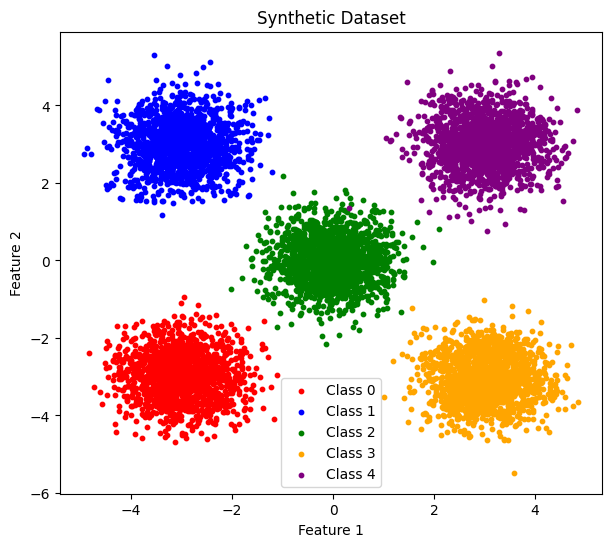

In [168]:
def generate_synthetic_data(samples_per_class):

    centers = [(-3,-3), (-3,3), (0,0), (3,-3), (3,3)]

    X_list = []
    y_list = []

    for class_id, (cx, cy) in enumerate(centers):
        # Generate Gaussian cluster around (cx, cy)
        points = np.random.randn(samples_per_class, 2) * 0.6 + np.array([cx, cy])
        X_list.append(points)
        y_list.append(np.full(samples_per_class, class_id))

    # Stack all classes together
    X = np.vstack(X_list)
    y = np.hstack(y_list)

    # Shuffle the dataset
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

# Generate data
X, y = generate_synthetic_data(1600)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

# Visualize
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(7,6))

for i in range(5):
    mask = (y == i)
    plt.scatter(X[mask, 0], X[mask, 1], s=10, c=colors[i], label=f"Class {i}")

plt.title("Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

**Train/Test Split**

In [169]:
def train_test_split_numpy(X, y, test_ratio=0.2):
    N = len(X)
    test_size = int(N * test_ratio)
    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test  = X[-test_size:]
    y_test  = y[-test_size:]
    return X_train, X_test, y_train, y_test

def one_hot_encode(y, num_classes):
    N = len(y)
    onehot = np.zeros((N, num_classes))
    for i in range(N):
        onehot[i, y[i]] = 1
    return onehot

num_classes = 5

# Split dataset
X_train, X_test, y_train, y_test = train_test_split_numpy(X, y, test_ratio=0.2)

mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

# One-hot encode labels
Y_train_oh = one_hot_encode(y_train, num_classes)
Y_test_oh  = one_hot_encode(y_test, num_classes)

print("Train X:", X_train_norm.shape, "Train Y one-hot:", Y_train_oh.shape)
print("Test  X:", X_test_norm.shape,  "Test  Y one-hot:", Y_test_oh.shape)

Train X: (6400, 2) Train Y one-hot: (6400, 5)
Test  X: (1600, 2) Test  Y one-hot: (1600, 5)


# **Code Modification**

In [170]:
class ThreeHiddenLayerNN:
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.1):
        self.lr = learning_rate

        # Weight matrices (He/Xavier-like scaling to keep activations stable)
        self.W_IH1  = np.random.randn(input_dim, h1)  / np.sqrt(input_dim)
        self.W_H1H2 = np.random.randn(h1, h2)  / np.sqrt(h1)
        self.W_H2H3 = np.random.randn(h2, h3)  / np.sqrt(h2)
        self.W_H3O  = np.random.randn(h3, output_dim) / np.sqrt(h3)

        # Bias terms initialized to zeros
        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, h3))
        self.b4 = np.zeros((1, output_dim))



# ----------------------- Activation Functions ---------------------- #

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        grad = np.zeros_like(x)
        grad[x > 0] = 1.0
        return grad

    def softmax(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


# -----------------------    Forward  Pass    ---------------------- #

    def feedForward(self, X):
        # Hidden layer 1
        self.z1 = np.dot(X, self.W_IH1) + self.b1
        self.a1 = self.relu(self.z1)

        # Hidden layer 2
        self.z2 = np.dot(self.a1, self.W_H1H2) + self.b2
        self.a2 = self.relu(self.z2)

        # Hidden layer 3
        self.z3 = np.dot(self.a2, self.W_H2H3) + self.b3
        self.a3 = self.relu(self.z3)

        # Output layer (logits then softmax probabilities)
        self.z4 = np.dot(self.a3, self.W_H3O) + self.b4
        self.a4 = self.softmax(self.z4)

        return self.a4

# ------------------     Loss: Cross-Entropy    ------------------- #

    def cross_entropy(self, Y_true, Y_pred):
        eps = 1e-8
        Y_pred_clipped = np.clip(Y_pred, eps, 1.0 - eps)
        ce = -np.sum(Y_true * np.log(Y_pred_clipped), axis=1)
        return np.mean(ce)


# --------------------     Backpropagation    --------------------- #

    def backPropagation(self, X, Y_true, Y_pred):
        N = X.shape[0]

        # ----- Output layer -----
        dZ4 = (Y_pred - Y_true) / N
        dW_H3O = np.dot(self.a3.T, dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # ----- Hidden layer 3 -----
        dA3 = np.dot(dZ4, self.W_H3O.T)
        dZ3 = dA3 * self.relu_derivative(self.z3)
        dW_H2H3 = np.dot(self.a2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # ----- Hidden layer 2 -----
        dA2 = np.dot(dZ3, self.W_H2H3.T)
        dZ2 = dA2 * self.relu_derivative(self.z2)
        dW_H1H2 = np.dot(self.a1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # ----- Hidden layer 1 -----
        dA1 = np.dot(dZ2, self.W_H1H2.T)
        dZ1 = dA1 * self.relu_derivative(self.z1)
        dW_IH1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # ----- Gradient descent update -----
        self.W_H3O  -= self.lr * dW_H3O
        self.b4     -= self.lr * db4

        self.W_H2H3 -= self.lr * dW_H2H3
        self.b3     -= self.lr * db3

        self.W_H1H2 -= self.lr * dW_H1H2
        self.b2     -= self.lr * db2

        self.W_IH1  -= self.lr * dW_IH1
        self.b1     -= self.lr * db1

# --------------------     Helper  methods    --------------------- #

    def train_step(self, X, Y_true):
        Y_pred = self.feedForward(X)
        loss = self.cross_entropy(Y_true, Y_pred)
        self.backPropagation(X, Y_true, Y_pred)
        return loss

    def predict_proba(self, X):
        return self.feedForward(X)

    def predict_class(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

**Training The Network**

In [171]:
input_dim = X_train_norm.shape[1]
h1, h2, h3 = 32, 24, 16
output_dim = num_classes

model = ThreeHiddenLayerNN(input_dim, h1, h2, h3, output_dim, learning_rate=0.1)

num_epochs = 3000
train_losses, test_losses = [], []
train_accs, test_accs = [], []

def accuracy_np(y_true, y_pred):
    return np.mean(y_true == y_pred)

for epoch in range(num_epochs):

    # Train on full batch
    loss_train = model.train_step(X_train_norm, Y_train_oh)
    train_losses.append(loss_train)

    # Evaluate on test set
    probs_test = model.predict_proba(X_test_norm)
    loss_test = model.cross_entropy(Y_test_oh, probs_test)
    test_losses.append(loss_test)

    # Accuracies
    pred_train = model.predict_class(X_train_norm)
    pred_test  = model.predict_class(X_test_norm)
    acc_train = accuracy_np(y_train, pred_train)
    acc_test  = accuracy_np(y_test, pred_test)
    train_accs.append(acc_train)
    test_accs.append(acc_test)

    if epoch % 300 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Train Loss = {loss_train:.4f}, Test Loss = {loss_test:.4f}, "
              f"Train Acc = {acc_train:.3f}, Test Acc = {acc_test:.3f}")

print("Training finished!")

Epoch    0 | Train Loss = 1.4722, Test Loss = 1.4273, Train Acc = 0.658, Test Acc = 0.648
Epoch  300 | Train Loss = 0.0151, Test Loss = 0.0154, Train Acc = 1.000, Test Acc = 0.999
Epoch  600 | Train Loss = 0.0059, Test Loss = 0.0072, Train Acc = 1.000, Test Acc = 0.999
Epoch  900 | Train Loss = 0.0038, Test Loss = 0.0056, Train Acc = 1.000, Test Acc = 0.999
Epoch 1200 | Train Loss = 0.0029, Test Loss = 0.0051, Train Acc = 1.000, Test Acc = 0.999
Epoch 1500 | Train Loss = 0.0024, Test Loss = 0.0050, Train Acc = 1.000, Test Acc = 0.999
Epoch 1800 | Train Loss = 0.0021, Test Loss = 0.0049, Train Acc = 1.000, Test Acc = 0.999
Epoch 2100 | Train Loss = 0.0018, Test Loss = 0.0050, Train Acc = 1.000, Test Acc = 0.999
Epoch 2400 | Train Loss = 0.0017, Test Loss = 0.0050, Train Acc = 1.000, Test Acc = 0.999
Epoch 2700 | Train Loss = 0.0016, Test Loss = 0.0051, Train Acc = 1.000, Test Acc = 0.999
Training finished!


# **Results and Analysis**

**Loss & accuracy curves**

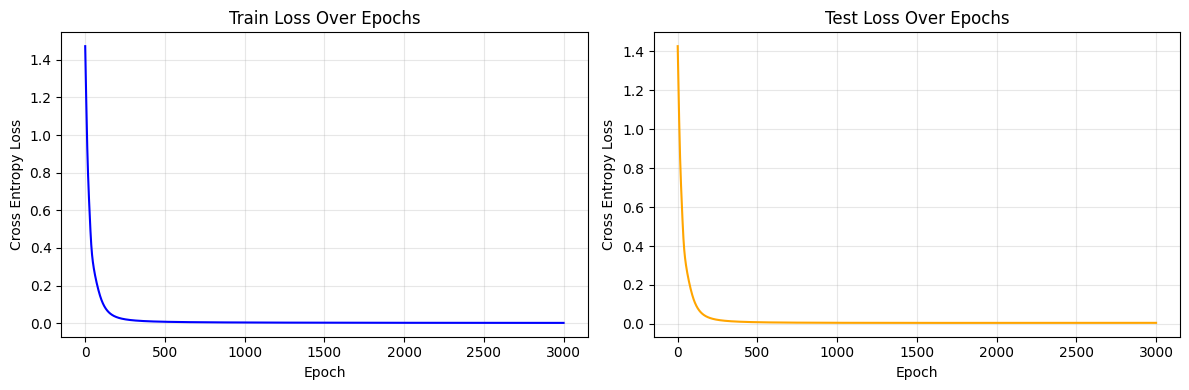

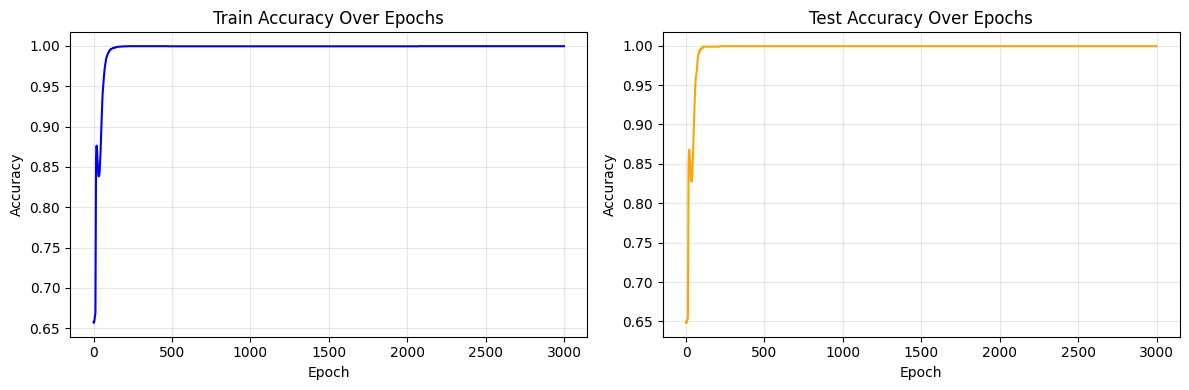

In [172]:
epochs_axis = np.arange(num_epochs)

plt.figure(figsize=(12, 4))

# Train Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, train_losses, color="blue")
plt.title("Train Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.grid(alpha=0.3)

# Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_axis, test_losses, color="orange")
plt.title("Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

# Train Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_axis, train_accs, color="blue")
plt.title("Train Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_axis, test_accs, color="orange")
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Confusion matrix**

Confusion Matrix (rows=true, cols=predicted):
[[313   0   0   0   0]
 [  0 316   0   0   0]
 [  0   0 325   0   0]
 [  0   0   0 326   0]
 [  0   0   1   0 319]]


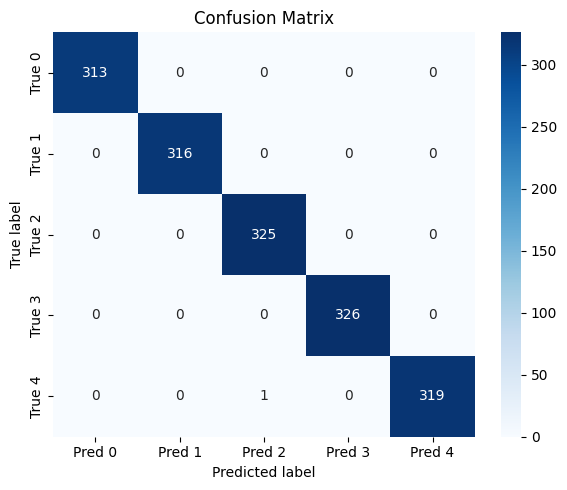


Per-class metrics on TEST set:
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=1.000, Recall=1.000, F1=1.000
Class 2: Precision=0.997, Recall=1.000, F1=0.998
Class 3: Precision=1.000, Recall=1.000, F1=1.000
Class 4: Precision=1.000, Recall=0.997, F1=0.998

Overall TEST accuracy: 0.999375
Macro-avg Precision: 0.9993865030674847
Macro-avg Recall   : 0.999375
Macro-avg F1       : 0.9993797912925582


In [173]:
y_test_pred = model.predict_class(X_test_norm)

def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix_np(y_test, y_test_pred, num_classes)
print("Confusion Matrix (rows=true, cols=predicted):")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

def precision_recall_f1_from_cm(cm):
    num_classes = cm.shape[0]
    precisions, recalls, f1s = [], [], []

    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = (2 * precision * recall / (precision + recall)
                     if (precision + recall) > 0 else 0.0)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.array(precisions), np.array(recalls), np.array(f1s)

precisions, recalls, f1s = precision_recall_f1_from_cm(cm)

print("\nPer-class metrics on TEST set:")
for c in range(num_classes):
    print(f"Class {c}: Precision={precisions[c]:.3f}, "
          f"Recall={recalls[c]:.3f}, F1={f1s[c]:.3f}")

overall_acc = accuracy_np(y_test, y_test_pred)
macro_precision = precisions.mean()
macro_recall = recalls.mean()
macro_f1 = f1s.mean()

print("\nOverall TEST accuracy:", overall_acc)
print("Macro-avg Precision:", macro_precision)
print("Macro-avg Recall   :", macro_recall)
print("Macro-avg F1       :", macro_f1)


**Decision Boundary**

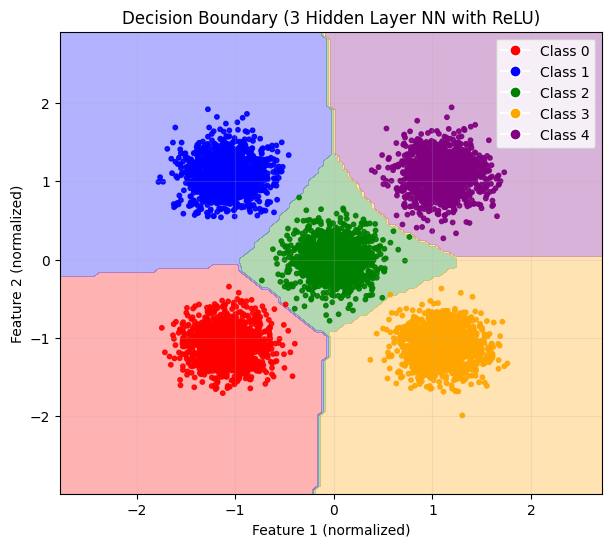

In [174]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmap = ListedColormap(colors[:num_classes])

h = 0.05
x_min, x_max = X_train_norm[:, 0].min() - 1, X_train_norm[:, 0].max() + 1
y_min, y_max = X_train_norm[:, 1].min() - 1, X_train_norm[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_class(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 6))

plt.contourf(xx, yy, Z,
             levels=np.arange(num_classes+1)-0.5,
             cmap=cmap, alpha=0.3)

plt.scatter(X_train_norm[:, 0],
            X_train_norm[:, 1],
            c=y_train, cmap=cmap,
            s=10, alpha=0.9)

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors[i], markersize=8,
               label=f"Class {i}")
    for i in range(num_classes)
]

plt.legend(handles=legend_handles)

plt.title("Decision Boundary (3 Hidden Layer NN with ReLU)")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.grid(alpha=0.2)
plt.show()

# **Code Modifications for Multi-Class Classification**

*   Changed output layer from 1 neuron → 5 neurons (one for each class)
*   Replaced sigmoid with softmax to output class probabilities
*   Replaced MSE loss with cross-entropy, the correct loss for softmax multi-class classification
*   Converted class labels into one-hot vectors (e.g., class 3 → [0,0,0,1,0])
*   Added three hidden layers and used ReLU activation
*   Extended backpropagation to handle 4 layers : Input → H1 → H2 → H3 → Output.



# Challenges & How They Were Solved


*   Slow/unstable training with sigmoid → switched to ReLU
*   Color mismatch in decision boundary → used one consistent colormap
*   Slow/unstable training with sigmoid → switched to ReLU
*   Shape mismatch errors during backpropropagation → verified matrix dimensions carefully



# Findings


*   The 3-hidden-layer neural network successfully learned to classify all 5 classes
*   Training and testing losses decreased suddenly
*   Achieved high overall accuracy and strong per-class precision/recall/F1.
*   Decision boundary plot shows clear separation between clusters.



# Lessons Learned

*  Multi-class classification requires Softmax + Cross-entropy + One-hot labels.

*  ReLU makes deeper networks train much better than sigmoid.
